In [1]:
# Data Collection and Preprocessing
## SYS819 - Autoencoder
### Charbel Nasr - NASC78350101


In [2]:
## Partie 1: Charger les données

In [3]:
import pandas as pd

failure_log = pd.read_excel("Historical-Failure-Logbook.xlsx")
scada_signals = pd.read_excel("Wind-Turbine-SCADA-signals.xlsx")
metmast_data = pd.read_excel("Onsite-MetMast-SCADA-data.xlsx")
turbine_logs = pd.read_excel("Wind-Turbines-Logs.xlsx")

print("------FAILURE_LOG-----------------------")
print(failure_log.head())
print("------SCADA_SIGNALS-----------------------")
print(scada_signals.head())
print("------METMAST_DATA-----------------------")
print(metmast_data.head())
print("------TURBINE_LOGS-----------------------")
print(turbine_logs.head())

------FAILURE_LOG-----------------------
  Turbine_ID          Component                  Timestamp  \
0        T01        TRANSFORMER  2017-08-11T13:14:00+00:00   
1        T06            GEARBOX  2017-10-17T08:38:00+00:00   
2        T06    HYDRAULIC_GROUP  2017-08-19T09:47:00+00:00   
3        T07  GENERATOR_BEARING  2017-08-20T06:08:00+00:00   
4        T07          GENERATOR  2017-08-21T14:47:00+00:00   

                      Remarks  
0     Transformer fan damaged  
1    Gearbox bearings damaged  
2          Oil leakage in Hub  
3  Generator bearings damaged  
4           Generator damaged  
------SCADA_SIGNALS-----------------------
  Turbine_ID                  Timestamp  Gen_RPM_Max  Gen_RPM_Min  \
0        T06  2017-12-29T20:30:00+00:00       1344.0        265.3   
1        T01  2017-12-29T20:30:00+00:00        289.9        238.5   
2        T06  2017-12-29T20:40:00+00:00        311.0        275.0   
3        T07  2017-12-29T20:40:00+00:00       1255.5       1239.3   
4     

In [4]:
## Partie 2: Nettoyage des données

In [5]:
print("les colonnes avec des valeurs manquantes :")
print("------SCADA_SIGNALS-----------------------")
print(scada_signals.isnull().sum())
print("------METMAST_DATA-----------------------")
print(metmast_data.isnull().sum())
print("------FAILURE_LOG-----------------------")
print(failure_log.isnull().sum())
print("------TURBINE_LOGS-----------------------")
print(turbine_logs.isnull().sum())


les colonnes avec des valeurs manquantes :
------SCADA_SIGNALS-----------------------
Turbine_ID               0
Timestamp                0
Gen_RPM_Max              0
Gen_RPM_Min              0
Gen_RPM_Avg              0
                        ..
Grd_Prod_PsbleCap_Max    0
Grd_Prod_PsbleCap_Min    0
Grd_Prod_PsbleCap_Std    0
Gen_Bear2_Temp_Avg       0
Nac_Direction_Avg        0
Length: 83, dtype: int64
------METMAST_DATA-----------------------
Timestamp                     0
Min_Windspeed1                1
Max_Windspeed1                0
Avg_Windspeed1                1
Var_Windspeed1                1
Min_Windspeed2                1
Max_Windspeed2                0
Avg_Windspeed2                1
Var_Windspeed2                1
Min_Winddirection2            1
Max_Winddirection2            0
Avg_Winddirection2            1
Var_Winddirection2            6
Min_AmbientTemp               1
Max_AmbientTemp               0
Avg_AmbientTemp               1
Min_Pressure                  1
Max_Pr

In [6]:
### Partie 2.1: METMAST_DATA - Nettoyage des données

In [7]:
numeric_columns = metmast_data.select_dtypes(include=['number']).columns

# Impute missing values for numeric columns
metmast_data[numeric_columns] = metmast_data[numeric_columns].fillna(metmast_data[numeric_columns].mean())

# Ensure 'Timestamp' is a valid datetime
metmast_data['Timestamp'] = pd.to_datetime(metmast_data['Timestamp'], errors='coerce')

# Drop rows where 'Timestamp' is missing
metmast_data.dropna(subset=['Timestamp'], inplace=True)

print(metmast_data.isnull().sum())

Timestamp                     0
Min_Windspeed1                0
Max_Windspeed1                0
Avg_Windspeed1                0
Var_Windspeed1                0
Min_Windspeed2                0
Max_Windspeed2                0
Avg_Windspeed2                0
Var_Windspeed2                0
Min_Winddirection2            0
Max_Winddirection2            0
Avg_Winddirection2            0
Var_Winddirection2            0
Min_AmbientTemp               0
Max_AmbientTemp               0
Avg_AmbientTemp               0
Min_Pressure                  0
Max_Pressure                  0
Avg_Pressure                  0
Min_Humidity                  0
Max_Humidity                  0
Avg_Humidity                  0
Min_Precipitation             0
Max_Precipitation             0
Avg_Precipitation             0
Min_Raindetection             0
Max_Raindetection             0
Avg_Raindetection             0
Anemometer1_Freq              0
Anemometer1_Offset            0
Anemometer1_CorrGain          0
Anemomet

In [8]:
### Partie 2.2: TURBINE_LOGS - Nettoyage des données

In [9]:
turbine_logs.dropna(subset=['Time_Detected', 'Remark'], inplace=True)
turbine_logs['Time_Reset'].fillna(turbine_logs['Time_Detected'], inplace=True)
turbine_logs.drop(['Unit_Title_Destination'], axis=1, inplace=True)

print(turbine_logs.isnull().sum())

Time_Detected         0
Time_Reset            0
Turbine_Identifier    0
Remark                0
dtype: int64


In [10]:
## Partie 3: Exclure les données d'échec

In [11]:
failure_log['Timestamp'] = pd.to_datetime(failure_log['Timestamp'])
scada_signals['Timestamp'] = pd.to_datetime(scada_signals['Timestamp'])

In [12]:
### Partie 3.1: pour supprimer les lignes basées sur l'id et timestamp
###             sur une fenêtre temporelle 5j.

In [13]:
from datetime import timedelta

def exclude_failures(scada_data, failure_data, exclusion_days=4):
    for _, failure in failure_data.iterrows():
        turbine_id = failure['Turbine_ID']
        failure_time = failure['Timestamp']

        exclusion_start = failure_time - timedelta(days=1)
        exclusion_end = failure_time + timedelta(days=exclusion_days)

        scada_data = scada_data[
            ~(
                (scada_data['Turbine_ID'] == turbine_id) &
                (scada_data['Timestamp'] >= exclusion_start) &
                (scada_data['Timestamp'] <= exclusion_end)
            )
        ]
    return scada_data

cleaned_scada_signals = exclude_failures(scada_signals, failure_log, exclusion_days=4)
print(f"Nmbr de lignes SCADA de départ: {len(scada_signals)}")
print(f"Nmbr de lignes SCADA après le nettoyage: {len(cleaned_scada_signals)}")
print(f"Nmbr de lignes supprimées: {len(scada_signals) - len(cleaned_scada_signals)}")

Nmbr de lignes SCADA de départ: 417141
Nmbr de lignes SCADA après le nettoyage: 403465
Nmbr de lignes supprimées: 13676


In [14]:
## Partie 4: Fusionner

In [15]:
### Partie 4.1: Fusionner les métadonnées et les données Scada

In [16]:
metmast_data = metmast_data.drop_duplicates(subset=['Timestamp'])
merged_data = pd.merge(cleaned_scada_signals, metmast_data, on='Timestamp', how='inner')
print(merged_data.isnull().sum())
print(f"SCADA_SIGNALS shape: {scada_signals.shape}")
print(f"METMAST_DATA shape: {metmast_data.shape}")
print(f"MERGED_DATA shape: {merged_data.shape}")

Turbine_ID                    0
Timestamp                     0
Gen_RPM_Max                   0
Gen_RPM_Min                   0
Gen_RPM_Avg                   0
                             ..
DistanceAirPress              0
AirRessureSensorZeroOffset    0
Anemometer1_Avg_Freq          0
Anemometer2_Avg_Freq          0
Pressure_Avg_Freq             0
Length: 123, dtype: int64
SCADA_SIGNALS shape: (417141, 83)
METMAST_DATA shape: (87528, 41)
MERGED_DATA shape: (333308, 123)


In [17]:
### Partie 4.2: Fusionner les données et les logs avec Embedding

In [18]:
turbine_logs['Remark_ID'] = turbine_logs['Remark'].astype('category').cat.codes
num_categories = turbine_logs['Remark_ID'].nunique()
print(f"Nombre de catégories uniques: {num_categories}")

Nombre de catégories uniques: 8645


In [19]:
import torch
import torch.nn as nn

# Define embedding parameters
num_categories = 8645  # Unique Remark categories
embedding_dim = 50

# Create the embedding layer
embedding_layer = nn.Embedding(num_categories, embedding_dim)

In [20]:
# Convert Remark_ID to a PyTorch tensor
remark_ids = torch.tensor(turbine_logs['Remark_ID'].values, dtype=torch.long)

# Generate embeddings and Convert embeddings to a NumPy array
remark_embeddings = embedding_layer(remark_ids).detach().numpy()

In [21]:
# Add embedding dimensions to the DataFrame
for i in range(embedding_dim):
    turbine_logs[f'Remark_Embedding_{i}'] = remark_embeddings[:, i]

print(turbine_logs.head())

               Time_Detected                 Time_Reset Turbine_Identifier  \
0  2017-05-10T08:44:37+00:00  2017-05-10T08:44:37+00:00                T01   
1  2017-05-07T09:10:55+00:00  2017-05-07T09:10:55+00:00                T01   
2  2017-08-24T13:01:56+00:00  2017-08-24T13:01:56+00:00                T06   
3  2017-05-02T14:25:06+00:00  2017-05-02T14:25:06+00:00                T06   
4  2017-05-02T14:47:40+00:00  2017-05-02T14:47:40+00:00                T01   

                            Remark  Remark_ID  Remark_Embedding_0  \
0         User    0 primary access       7144            0.685982   
1       External power ref.:2000kW       1887            1.186482   
2  Nac.vent.1, nac/gear: 38/ 48Â°C       4089           -0.541616   
3       External power ref.:2000kW       1887            1.186482   
4       External power ref.:2000kW       1887            1.186482   

   Remark_Embedding_1  Remark_Embedding_2  Remark_Embedding_3  \
0           -0.978974           -0.210803          

In [22]:
turbine_logs['Time_Detected'] = pd.to_datetime(turbine_logs['Time_Detected'])
merged_data['Timestamp'] = pd.to_datetime(merged_data['Timestamp'])
turbine_logs['Time_Detected'] = turbine_logs['Time_Detected'].dt.round('10min')

#Merge logs into the main dataset
final_data = pd.merge(
    merged_data,
    turbine_logs,
    left_on=['Timestamp', 'Turbine_ID'],
    right_on=['Time_Detected', 'Turbine_Identifier'],
    how='left'
)

# Drop unnecessary columns after the merge
final_data.drop(['Time_Detected', 'Turbine_Identifier'], axis=1, inplace=True)

print(f"SCADA_SIGNALS shape: {merged_data.shape}")
print(f"METMAST_DATA shape: {turbine_logs.shape}")
print(f"MERGED_DATA shape: {final_data.shape}")

SCADA_SIGNALS shape: (333308, 123)
METMAST_DATA shape: (252607, 55)
MERGED_DATA shape: (416115, 176)


In [23]:
print(final_data.isnull().sum())

Turbine_ID                  0
Timestamp                   0
Gen_RPM_Max                 0
Gen_RPM_Min                 0
Gen_RPM_Avg                 0
                        ...  
Remark_Embedding_45    209578
Remark_Embedding_46    209578
Remark_Embedding_47    209578
Remark_Embedding_48    209578
Remark_Embedding_49    209578
Length: 176, dtype: int64


In [24]:
# Identify embedding columns
embedding_columns = [col for col in final_data.columns if col.startswith('Remark_Embedding_')]

# Add a binary flag for presence of logs
final_data['Has_Log'] = final_data[embedding_columns].notnull().any(axis=1).astype(int)

# Fill missing embeddings with zeros
final_data[embedding_columns] = final_data[embedding_columns].fillna(0)

print(final_data.isnull().sum())

print(final_data.head())

Turbine_ID             0
Timestamp              0
Gen_RPM_Max            0
Gen_RPM_Min            0
Gen_RPM_Avg            0
                      ..
Remark_Embedding_46    0
Remark_Embedding_47    0
Remark_Embedding_48    0
Remark_Embedding_49    0
Has_Log                0
Length: 177, dtype: int64
  Turbine_ID                 Timestamp  Gen_RPM_Max  Gen_RPM_Min  Gen_RPM_Avg  \
0        T06 2017-12-29 20:30:00+00:00       1344.0        265.3        647.1   
1        T01 2017-12-29 20:30:00+00:00        289.9        238.5        265.5   
2        T11 2017-12-29 20:30:00+00:00       1259.3       1234.4       1248.7   
3        T07 2017-12-29 20:30:00+00:00       1259.9       1234.3       1248.4   
4        T06 2017-12-29 20:40:00+00:00        311.0        275.0        293.1   

   Gen_RPM_Std  Gen_Bear_Temp_Avg  Gen_Phase1_Temp_Avg  Gen_Phase2_Temp_Avg  \
0        476.4               43.0                   56                   57   
1         13.1               40.0                   54

In [25]:
final_data = final_data.drop(columns=['Time_Reset'])
final_data = final_data.drop(columns=['Remark'])
final_data = final_data.drop(columns=['Remark_ID'])

# Drop rows with missing critical values
final_data = final_data.dropna(subset=['Grd_Prod_CosPhi_Avg', 'Gen_Bear_Temp_Avg'])

# Save null counts to a CSV
null_counts = final_data.isnull().sum().reset_index()
null_counts.columns = ['Column', 'Null_Count']
null_counts.to_csv("null_counts.csv", index=False)


In [26]:
### Partie 5: downsampling

In [27]:
# Define the cut-in speed for turbines (replace 3 with your turbine's actual cut-in speed if known)
cut_in_speed = 3  # Wind speed in m/s

# Separate non-operational and operational data
non_operational = final_data[(final_data['Gen_RPM_Std'] == 0) & 
                             (final_data['Amb_WindSpeed_Avg'] < cut_in_speed)]
operational_data = final_data[(final_data['Gen_RPM_Std'] > 0) | 
                              (final_data['Amb_WindSpeed_Avg'] >= cut_in_speed)]

# Downsample non-operational data (e.g., retain 10%)
downsampled_non_operational = non_operational.sample(frac=0.1, random_state=42)

# Combine operational and downsampled non-operational data
balanced_data = pd.concat([operational_data, downsampled_non_operational], axis=0)

# Shuffle the data to mix operational and non-operational periods
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Original dataset size: {len(final_data)}")
print(f"Operational data size: {len(operational_data)}")
print(f"Non-operational data size (before downsampling): {len(non_operational)}")
print(f"Non-operational data size (after downsampling): {len(downsampled_non_operational)}")
print(f"Balanced dataset size: {len(balanced_data)}")

Original dataset size: 416103
Operational data size: 400324
Non-operational data size (before downsampling): 15779
Non-operational data size (after downsampling): 1578
Balanced dataset size: 401902


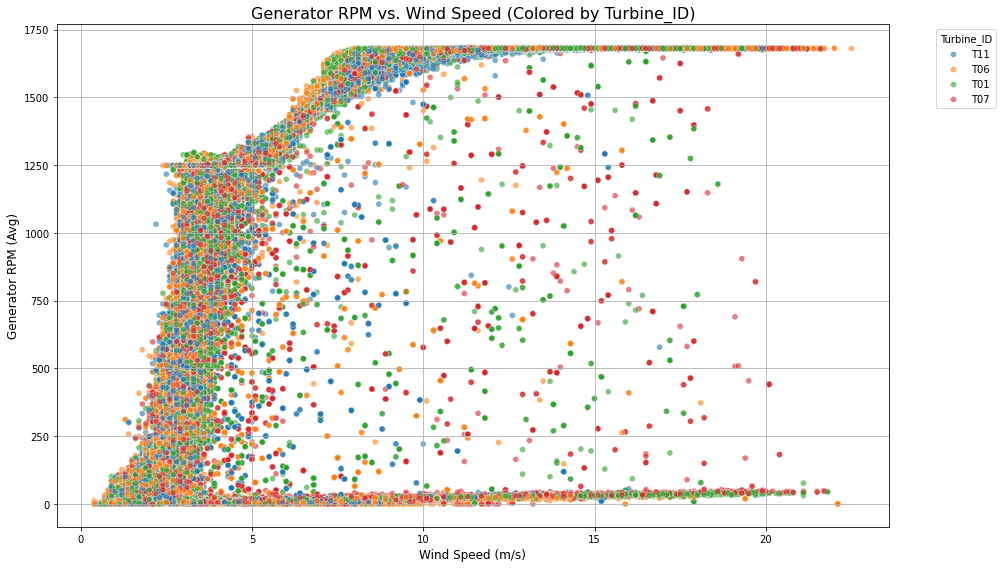

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the scatter plot with Turbine_ID as hue
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=balanced_data,
    x='Amb_WindSpeed_Avg',       # Average wind speed
    y='Gen_RPM_Avg',             # Average generator RPM
    hue='Turbine_ID',            # Differentiate points based on Turbine_ID
    palette='tab10',             # Use a color palette for unique turbine IDs
    alpha=0.6                    # Transparency for overlapping points
)

# Enhancing the plot
plt.title('Generator RPM vs. Wind Speed (Colored by Turbine_ID)', fontsize=16)
plt.xlabel('Wind Speed (m/s)', fontsize=12)
plt.ylabel('Generator RPM (Avg)', fontsize=12)
plt.legend(title='Turbine_ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [29]:
## Partie 6: Standardization

In [30]:
from sklearn.preprocessing import StandardScaler
import joblib

# Identify columns
non_numeric_columns = ['Turbine_ID', 'Timestamp']
embedding_columns = [col for col in balanced_data.columns if col.startswith('Remark_Embedding_')]
exclude_columns = non_numeric_columns + embedding_columns + ['Has_Log']

# Features to scale (excluding embeddings and Has_Log)
features_to_scale = balanced_data.drop(columns=exclude_columns)

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features_to_scale)

# Save the scaler for future use
joblib.dump(scaler, "scaler.pkl")

# Combine the scaled features, Has_Log, embeddings, and non-numeric columns
scaled_df = pd.DataFrame(scaled_data, columns=features_to_scale.columns)
final_scaled_data = pd.concat(
    [
        balanced_data[non_numeric_columns + ['Has_Log'] + embedding_columns].reset_index(drop=True),
        scaled_df,
    ],
    axis=1,
)

print("Les données ont été normalisées")


Les données ont été normalisées


In [31]:
### Partie 6.1:  Features constantes

In [32]:
# Inspect the scaled features
# Identify constant features (std == 0)
### Partie 6.1: Features constantes

# Compute the standard deviations for scaled features
scaled_stds = scaled_df.std()  # Calculate standard deviations for all columns in scaled_df

# Identify constant features (features with std == 0)
constant_features = scaled_stds[scaled_stds == 0].index.tolist()
print(f"Constant features (std = 0): {constant_features}")

# Drop constant features from the dataset
scaled_df = scaled_df.drop(columns=constant_features)

# Save the updated scaled dataset with constant features removed
final_scaled_data = pd.concat(
    [
        balanced_data[non_numeric_columns + ['Has_Log'] + embedding_columns].reset_index(drop=True),
        scaled_df,
    ],
    axis=1,
)

print(f"Features restantes après élimination des constantes: {scaled_df.shape[1]}")



Constant features (std = 0): ['Prod_LatestAvg_ActPwrGen2', 'Prod_LatestAvg_ReactPwrGen2', 'Min_Raindetection', 'Avg_Raindetection', 'Anemometer1_Freq', 'Anemometer1_Offset', 'Anemometer1_CorrGain', 'Anemometer1_CorrOffset', 'Anemometer2_Freq', 'Anemometer2_Offset', 'Anemometer2_CorrGain', 'Anemometer2_CorrOffset', 'DistanceAirPress', 'AirRessureSensorZeroOffset']
Features restantes après élimination des constantes: 107


In [33]:
### Partie 6.2: Vérifier Standardization

In [34]:
import numpy as np
scaled_means = scaled_df.mean()
scaled_stds = scaled_df.std()

# Check if mean is approximately 0 and standard deviation is approximately 1
print("Mean of scaled features:")
print(scaled_means)

print("\nStandard deviation of scaled features:")
print(scaled_stds)

# Check if all means are close to 0 and stds are close to 1
if np.allclose(scaled_means, 0, atol=1e-2) and np.allclose(scaled_stds, 1, atol=1e-2):
    print("Scaling is correct: Means are close to 0 and standard deviations are close to 1.")
else:
    print("Scaling may be incorrect: Check the means and standard deviations above.")

Mean of scaled features:
Gen_RPM_Max            -1.056474e-15
Gen_RPM_Min             2.410423e-16
Gen_RPM_Avg            -2.293208e-16
Gen_RPM_Std             5.676888e-17
Gen_Bear_Temp_Avg      -7.794893e-17
                            ...     
Avg_Precipitation       8.822072e-18
Max_Raindetection       1.555796e-18
Anemometer1_Avg_Freq   -7.273347e-17
Anemometer2_Avg_Freq   -4.980316e-17
Pressure_Avg_Freq       5.124642e-15
Length: 107, dtype: float64

Standard deviation of scaled features:
Gen_RPM_Max             1.000001
Gen_RPM_Min             1.000001
Gen_RPM_Avg             1.000001
Gen_RPM_Std             1.000001
Gen_Bear_Temp_Avg       1.000001
                          ...   
Avg_Precipitation       1.000001
Max_Raindetection       1.000001
Anemometer1_Avg_Freq    1.000001
Anemometer2_Avg_Freq    1.000001
Pressure_Avg_Freq       1.000001
Length: 107, dtype: float64
Scaling is correct: Means are close to 0 and standard deviations are close to 1.


In [35]:
# Inspect Has_Log column
print("Unique values in 'Has_Log':", final_scaled_data['Has_Log'].unique())

# Check if Has_Log contains only binary values (0 and 1)
if set(final_scaled_data['Has_Log'].unique()) == {0, 1}:
    print("'Has_Log' column is intact and contains only binary values.")
else:
    print("Something went wrong with the 'Has_Log' column. Verify the data.")


Unique values in 'Has_Log': [0 1]
'Has_Log' column is intact and contains only binary values.


In [36]:
# Inspect embeddings
print("Summary statistics for embedding columns:")
print(final_scaled_data[embedding_columns].describe())

# Check if embeddings contain non-standardized values (no change)
if np.allclose(
    final_scaled_data[embedding_columns].mean().values, 
    balanced_data[embedding_columns].mean().values
):
    print("Embedding columns are intact and unaltered.")
else:
    print("Embedding columns were modified. Verify the data.")


Summary statistics for embedding columns:
       Remark_Embedding_0  Remark_Embedding_1  Remark_Embedding_2  \
count       401902.000000       401902.000000       401902.000000   
mean             0.409809           -0.320671           -0.221490   
std              0.839521            0.639825            0.749802   
min             -3.527183           -4.298314           -3.793674   
25%              0.000000           -0.804575           -0.999482   
50%              0.000000            0.000000            0.000000   
75%              1.186482            0.000000            0.000000   
max              3.644537            3.788625            3.785335   

       Remark_Embedding_3  Remark_Embedding_4  Remark_Embedding_5  \
count       401902.000000       401902.000000       401902.000000   
mean             0.037122            0.244897           -0.384051   
std              0.515315            0.707887            0.677564   
min             -3.618092           -3.551369           -4.3

In [37]:
print("Original number of rows:", len(balanced_data))
print("Processed number of rows:", len(final_scaled_data))

if len(balanced_data) == len(final_scaled_data):
    print("Row count is correct.")
else:
    print("Row count mismatch. Verify the merging process.")

Original number of rows: 401902
Processed number of rows: 401902
Row count is correct.


In [38]:
## Partie 7: analyse

In [39]:
# Convert column names to a list and print
all_columns = balanced_data.columns.tolist()
print(all_columns)

['Turbine_ID', 'Timestamp', 'Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_RPM_Avg', 'Gen_RPM_Std', 'Gen_Bear_Temp_Avg', 'Gen_Phase1_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg', 'Hyd_Oil_Temp_Avg', 'Gear_Oil_Temp_Avg', 'Gear_Bear_Temp_Avg', 'Nac_Temp_Avg', 'Rtr_RPM_Max', 'Rtr_RPM_Min', 'Rtr_RPM_Avg', 'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min', 'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Std', 'Amb_WindDir_Relative_Avg', 'Amb_WindDir_Abs_Avg', 'Amb_Temp_Avg', 'Prod_LatestAvg_ActPwrGen0', 'Prod_LatestAvg_ActPwrGen1', 'Prod_LatestAvg_ActPwrGen2', 'Prod_LatestAvg_TotActPwr', 'Prod_LatestAvg_ReactPwrGen0', 'Prod_LatestAvg_ReactPwrGen1', 'Prod_LatestAvg_ReactPwrGen2', 'Prod_LatestAvg_TotReactPwr', 'HVTrafo_Phase1_Temp_Avg', 'HVTrafo_Phase2_Temp_Avg', 'HVTrafo_Phase3_Temp_Avg', 'Grd_InverterPhase1_Temp_Avg', 'Cont_Top_Temp_Avg', 'Cont_Hub_Temp_Avg', 'Cont_VCP_Temp_Avg', 'Gen_SlipRing_Temp_Avg', 'Spin_Temp_Avg', 'Blds_PitchAngle_Min', 'Blds_PitchAngle_Max', 'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Std', 

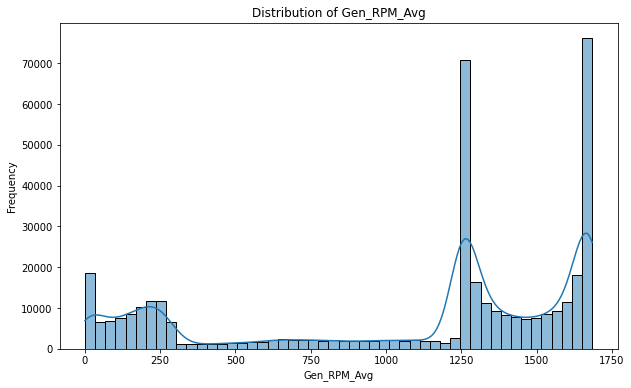

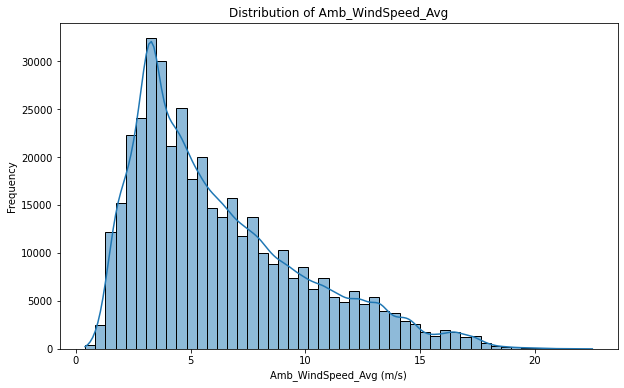

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.histplot(balanced_data['Gen_RPM_Avg'], bins=50, kde=True)
plt.title("Distribution of Gen_RPM_Avg")
plt.xlabel("Gen_RPM_Avg")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(balanced_data['Amb_WindSpeed_Avg'], bins=50, kde=True)
plt.title("Distribution of Amb_WindSpeed_Avg")
plt.xlabel("Amb_WindSpeed_Avg (m/s)")
plt.ylabel("Frequency")
plt.show()

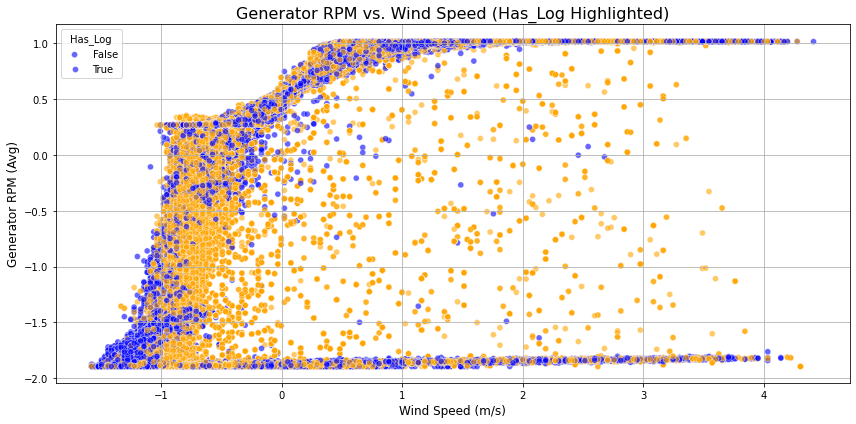

In [41]:
# Create the scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=final_scaled_data,
    x='Amb_WindSpeed_Avg',       # Average wind speed
    y='Gen_RPM_Avg',             # Average generator RPM
    hue='Has_Log',               # Differentiate points based on Has_Log
    palette={0: 'blue', 1: 'orange'},  # Assign colors: blue for False, orange for True
    alpha=0.6                    # Transparency for overlapping points
)

# Enhancing the plot
plt.title('Generator RPM vs. Wind Speed (Has_Log Highlighted)', fontsize=16)
plt.xlabel('Wind Speed (m/s)', fontsize=12)
plt.ylabel('Generator RPM (Avg)', fontsize=12)
plt.legend(title='Has_Log', labels=['False', 'True'])
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [42]:
final_scaled_data.to_csv("final_data.csv", index=False)